In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Convert string to DataFrame (replace with pd.read_csv if using a file)
from io import StringIO
df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\FORECASTING BUSINESS PERFORMANCE.csv")

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Aggregate by Date, summing Units and Revenue
daily_data = df.groupby('Date')[['Units', 'Revenue']].sum().reset_index()

# Create a complete date range and fill missing days with 0
start_date = daily_data['Date'].min()
end_date = daily_data['Date'].max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
daily_data = daily_data.set_index('Date').reindex(all_dates).fillna(0).reset_index()
daily_data.columns = ['Date', 'Units', 'Revenue']

# Split into Units and Revenue series
units_series = daily_data[['Date', 'Units']].set_index('Date')
revenue_series = daily_data[['Date', 'Revenue']].set_index('Date')

# Function to check stationarity
def check_stationarity(series):
    result = adfuller(series.dropna())
    return result[1] < 0.05  # p-value < 0.05 means stationary

# ARIMA Optimization
def optimize_arima(series, p_range, d_range, q_range):
    best_aic = float('inf')
    best_order = None
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(series, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                except:
                    continue
    return best_order, best_aic

# LSTM Data Preparation
def prepare_lstm_data(series, lookback):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    train_size = int(len(X) * 0.8)
    return X[:train_size], y[:train_size], X[train_size:], y[train_size:], scaler

# Optimize LSTM
def optimize_lstm(X_train, y_train, X_test, y_test, lookbacks, units_list, epochs_list, batch_sizes):
    best_rmse = float('inf')
    best_params = None
    for lookback in lookbacks:
        X_train_lb, y_train_lb, X_test_lb, y_test_lb, scaler = prepare_lstm_data(pd.Series(y_train_lb), lookback)
        for units in units_list:
            for epochs in epochs_list:
                for batch_size in batch_sizes:
                    model = Sequential()
                    model.add(LSTM(units, input_shape=(lookback, 1)))
                    model.add(Dense(1))
                    model.compile(optimizer='adam', loss='mse')
                    model.fit(X_train_lb, y_train_lb, epochs=epochs, batch_size=batch_size, verbose=0)
                    predictions = model.predict(X_test_lb)
                    predictions = scaler.inverse_transform(predictions)
                    y_test_inv = scaler.inverse_transform([y_test_lb])
                    rmse = np.sqrt(mean_squared_error(y_test_inv[0], predictions[:, 0]))
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = (lookback, units, epochs, batch_size)
    return best_params, best_rmse

# Forecast function for ARIMA
def forecast_arima(series, order, steps):
    model = ARIMA(series, order=order)
    results = model.fit()
    forecast = results.forecast(steps=steps)
    return forecast

# Forecast function for LSTM
def forecast_lstm(series, lookback, units, epochs, batch_size, steps, scaler):
    X, y, _, _, scaler = prepare_lstm_data(series, lookback)
    model = Sequential()
    model.add(LSTM(units, input_shape=(lookback, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
    last_sequence = series[-lookback:].values.reshape(-1, 1)
    last_sequence = scaler.transform(last_sequence)
    forecast = []
    for _ in range(steps):
        next_pred = model.predict(last_sequence.reshape(1, lookback, 1), verbose=0)
        forecast.append(next_pred[0, 0])
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[-1] = next_pred[0, 0]
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    return forecast

# Optimize and forecast for Units
print("Optimizing ARIMA for Units...")
if not check_stationarity(units_series['Units']):
    d_range = range(1, 3)
else:
    d_range = [0]
best_order_units, best_aic_units = optimize_arima(units_series['Units'], range(0, 4), d_range, range(0, 4))
print(f"Best ARIMA order for Units: {best_order_units}, AIC: {best_aic_units}")

print("Optimizing LSTM for Units...")
X_train_u, y_train_u, X_test_u, y_test_u, scaler_u = prepare_lstm_data(units_series['Units'], 7)
best_params_units, best_rmse_units = optimize_lstm(X_train_u, y_train_u, X_test_u, y_test_u, [7, 14, 30], [50, 100], [50, 100], [32, 64])
print(f"Best LSTM params for Units: {best_params_units}, RMSE: {best_rmse_units}")

# Optimize and forecast for Revenue
print("Optimizing ARIMA for Revenue...")
if not check_stationarity(revenue_series['Revenue']):
    d_range = range(1, 3)
else:
    d_range = [0]
best_order_revenue, best_aic_revenue = optimize_arima(revenue_series['Revenue'], range(0, 4), d_range, range(0, 4))
print(f"Best ARIMA order for Revenue: {best_order_revenue}, AIC: {best_aic_revenue}")

print("Optimizing LSTM for Revenue...")
X_train_r, y_train_r, X_test_r, y_test_r, scaler_r = prepare_lstm_data(revenue_series['Revenue'], 7)
best_params_revenue, best_rmse_revenue = optimize_lstm(X_train_r, y_train_r, X_test_r, y_test_r, [7, 14, 30], [50, 100], [50, 100], [32, 64])
print(f"Best LSTM params for Revenue: {best_params_revenue}, RMSE: {best_rmse_revenue}")

# Forecast for the next year (365 days)
forecast_steps = 365
forecast_dates = pd.date_range(start=end_date + timedelta(days=1), periods=forecast_steps, freq='D')

# ARIMA Forecasts
arima_forecast_units = forecast_arima(units_series['Units'], best_order_units, forecast_steps)
arima_forecast_revenue = forecast_arima(revenue_series['Revenue'], best_order_revenue, forecast_steps)

# LSTM Forecasts
lstm_forecast_units = forecast_lstm(units_series['Units'], *best_params_units, forecast_steps, scaler_u)
lstm_forecast_revenue = forecast_lstm(revenue_series['Revenue'], *best_params_revenue, forecast_steps, scaler_r)

# Combine forecasts into DataFrames
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'ARIMA_Units': arima_forecast_units,
    'LSTM_Units': lstm_forecast_units.flatten(),
    'ARIMA_Revenue': arima_forecast_revenue,
    'LSTM_Revenue': lstm_forecast_revenue.flatten()
})

# Plotting
plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(units_series.index, units_series['Units'], label='Historical Units')
plt.plot(forecast_df['Date'], forecast_df['ARIMA_Units'], label='ARIMA Forecast')
plt.plot(forecast_df['Date'], forecast_df['LSTM_Units'], label='LSTM Forecast')
plt.title('Units Forecast')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(revenue_series.index, revenue_series['Revenue'], label='Historical Revenue')
plt.plot(forecast_df['Date'], forecast_df['ARIMA_Revenue'], label='ARIMA Forecast')
plt.plot(forecast_df['Date'], forecast_df['LSTM_Revenue'], label='LSTM Forecast')
plt.title('Revenue Forecast')
plt.legend()

plt.tight_layout()
plt.show()

# Save forecasts to CSV
forecast_df.to_csv('forecast_results.csv', index=False)
print("Forecasts saved to 'forecast_results.csv'")

Optimizing ARIMA for Units...
Best ARIMA order for Units: (3, 0, 2), AIC: 60666.81292329775
Optimizing LSTM for Units...


UnboundLocalError: cannot access local variable 'y_train_lb' where it is not associated with a value

In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

# Đọc dữ liệu
train_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv")
test_df = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv")

# Giả sử cột cần dự báo là 'Units'
train_series = train_df['Units']
test_series = test_df['Units']

# Hàm huấn luyện và dự báo với ARIMA(3,0,2)
def arima_model(series, test_index, forecast_steps=12):
    model = ARIMA(series, order=(3, 0, 2))
    results = model.fit()
    forecast = results.get_forecast(steps=forecast_steps).predicted_mean
    test_pred = results.predict(start=test_index[0], end=test_index[-1])
    return test_pred, forecast

# Chạy mô hình
arima_test_pred, arima_forecast = arima_model(train_series, test_series.index)

# Hàm đánh giá mô hình
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return {'R²': r2, 'MAPE': mape, 'RMSE': rmse}

# Tính toán các chỉ số đánh giá
arima_metrics = evaluate_model(test_series[:len(arima_test_pred)], arima_test_pred)
print("ARIMA Metrics:", arima_metrics)


ARIMA Metrics: {'R²': -7.169972614863237, 'MAPE': 0.2964801598524053, 'RMSE': 0.9153450170252236}


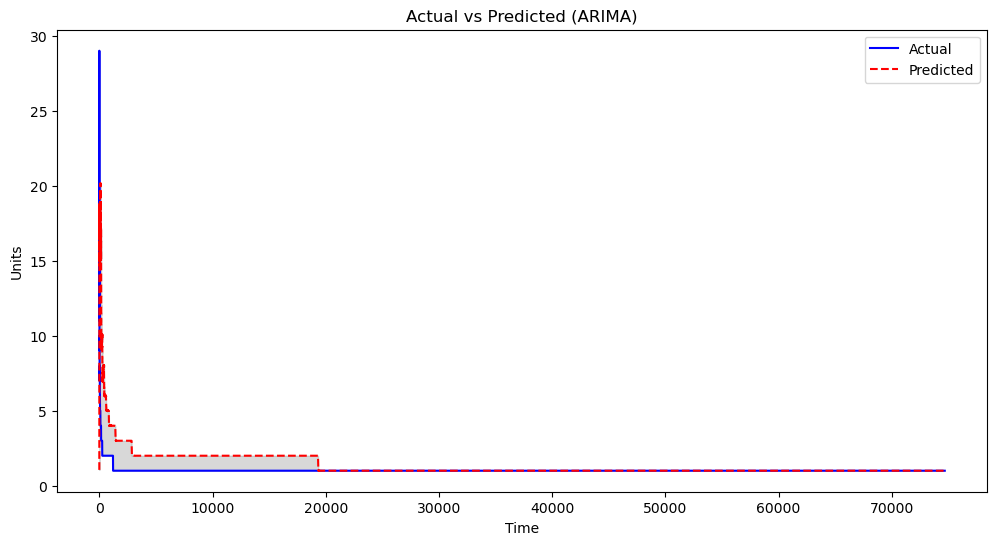

In [7]:
# Vẽ biểu đồ sai số
plt.figure(figsize=(12, 6))
plt.plot(test_series[:len(arima_test_pred)].index, test_series[:len(arima_test_pred)], label="Actual", color="blue")
plt.plot(test_series[:len(arima_test_pred)].index, arima_test_pred, label="Predicted", color="red", linestyle="dashed")
plt.fill_between(test_series[:len(arima_test_pred)].index, test_series[:len(arima_test_pred)], arima_test_pred, color='gray', alpha=0.3)
plt.xlabel("Time")
plt.ylabel("Units")
plt.title("Actual vs Predicted (ARIMA)")
plt.legend()
plt.show()